## GSD Tokenomics
#### Analysis contains the following:
* Price control schedule proposal
* Supply and price projections

* 3% Backers / Partnership (1% Sys, 1% Lode, Jag (0.7% + 0.3%) 
* 7% Early Contributors ( 2%, 1% L, 1% K, 1% G, 0.8% Simon, 0.8% Augusto + 0.4% Big booba ) 
* 5% Foundation (Legal, operation, marketing, acquisition)  - No vesting
* 30% TGE, weekly release up to 3 years

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
btc_historical = pd.read_csv('../resources/btc_historical.csv')
eth_historical = pd.read_csv('../resources/eth_historical.csv')

#### Generate random sequence

In [3]:
def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def gen_random_capital(N):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(0, 1, 1), initialization='diffuse')
    simulations = mod.simulate([-5/3, 5/6, 4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = 100, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 2, xs=t)

    sim = (s + np.abs(simulations))*np.exp(y_samp.flatten())
    sim_block_occupancy = np.abs(simulations)/max(np.abs(simulations))
    
    return sim_block_occupancy

#### Formatting functions

In [4]:
def getDate(t, strt_date):
    return datetime.datetime.strptime(strt_date, "%Y-%m-%d") + datetime.timedelta(days=t) 

def func(x, p1, p2):
    return p1*np.log(x) + p2

def x2Percent(x):
    return 100*(x - 1)

def percent2X(percent):
    return 1 + percent/100

def apy2Rebase(apy,f):
    x = percent2X(apy)
    return 100*(x**(1/f) - 1)

def unit_return(token, apy, t, freq = 12):
    multiplier = 1 + apy/100
    return token*(multiplier)**(t/freq)

def compound_return(rebase, freq=12, deposit=1):
    return deposit*(1+rebase/100)**(freq)

def apy_return(rebase,freq):
    annualX = compound_return(rebase,freq)
    return x2Percent(annualX)

def time_units_between(a0,a1,rebase):
    return np.log(a1/a0)/np.log(1+rebase/100)

In [5]:
STRT_DATE_BTC = btc_historical['Date'].values[0]
N_BTC = len(btc_historical)

Np = 365*10
ydata = np.log(btc_historical['Price'].values)
xdata = [x+1 for x in range(len(btc_historical))] #just use numbers for dates
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10))
price_pred = func(np.array([x+1 for x in range(N_BTC+Np)]), popt[0], popt[1])#pass values to function
dates_pred = np.array([getDate(t, STRT_DATE_BTC) for t in range(N_BTC+Np)])


#### BTC Logarithmic projections

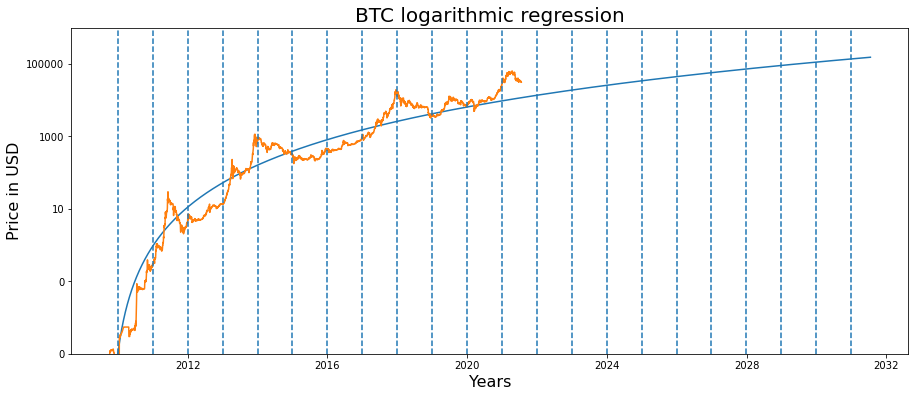

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.yscale('log', subs=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dates_pred, np.exp(price_pred)) #exponentiate the data
plt.plot(dates_pred[:N_BTC], btc_historical['Price'].values) #exponentiate the data
plt.title("BTC logarithmic regression", fontsize=20)
plt.ylabel("Price in USD", fontsize=16)
plt.xlabel('Years', fontsize=16)
plt.ylim(bottom=0.001)
for k in range(88,N_BTC+Np,365):
    plt.axvline(x=dates_pred[k],linestyle='--')
plt.show()
fig.savefig('../img/btc_log_model.png')

In [7]:
yoy = []
for k in range(1,N_BTC+Np,365):
    yoy.append(np.exp(price_pred[k]))
yoy = np.array(yoy) 

apy_btc = 100*(yoy[1:]-yoy[:len(yoy)-1])/yoy[:len(yoy)-1]
btc_yrs = np.linspace(1, len(apy_btc), num=len(apy_btc))

In [8]:
STRT_DATE_ETH = eth_historical['time'].values[0]
N_ETH = len(eth_historical)

Np = 365*10
ydata = np.log(eth_historical['close'].values)
xdata = [x+1 for x in range(len(eth_historical))] #just use numbers for dates
popt, pcov = curve_fit(func, xdata, ydata, p0=(3.0, -10))
price_pred = func(np.array([x+1 for x in range(N_ETH+Np)]), popt[0], popt[1])#pass values to function
dates_pred = np.array([getDate(t, STRT_DATE_ETH) for t in range(N_ETH+Np)])


#### ETH Logarithmic projections

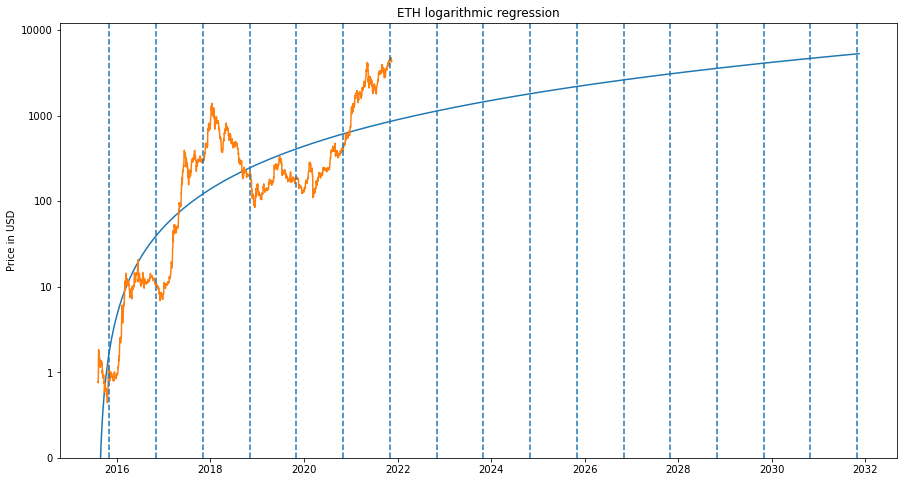

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.yscale('log', subs=[1])
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(dates_pred, np.exp(price_pred)) #exponentiate the data
plt.plot(dates_pred[:N_ETH], eth_historical['close'].values) #exponentiate the data
plt.title("ETH logarithmic regression")
plt.ylabel("Price in USD")
plt.ylim(bottom=0.1)
for k in range(88,N_ETH+Np,365):
    plt.axvline(x=dates_pred[k],linestyle='--')
plt.show()

In [10]:
yoy = []
for k in range(1,N_ETH+Np,365):
    yoy.append(np.exp(price_pred[k]))
yoy = np.array(yoy) 

apy_eth = 100*(yoy[1:]-yoy[:len(yoy)-1])/yoy[:len(yoy)-1]
eth_yrs = np.linspace(1, len(apy_eth), num=len(apy_eth))

#### Proposed price control schedule

Given supply level of $1 \times 10^{6+k}$, we propose a price control of

$P_{k} = \frac{P_{0}}{\phi^{k}}$, where
* $P_{0}$ is the initial price
* $P_{k}$ is the price at the supply changeover to next order of magnitude
* $\phi$ is the golden ratio

In [11]:
PHI = 1.6180339887
# supply = np.array([1e5,1e6,1e7,1e8,1e9,1e10,1e11,1e12]) # Olympus
# supply = np.array([250000,1e7,1e8,1e9,1e10,1e11,1e12]) # GSD 1
# supply = np.array([250000,1e7,1e8,1e9,1e10,1e11,1e12]) # GSD 2
supply = np.array([200000,1e7,1e8,1e9,1e10,1e11,1e12]) # GSD 3
p_control_schedule = np.array([1/(PHI**k) for k in range(len(supply))])

In [12]:
# apy_schedule = np.array([1e4,1e3,500,100,25,6,3]) # Olympus
# apy_schedule = np.array([5000,1500,500,100,25,6]) # GSD 1
# apy_schedule = np.array([12000,2000,500,100,25,6]) # GSD 2
apy_schedule = np.array([30000,3000,500,100,25,6]) # GSD 3
rebase = apy2Rebase(apy_schedule,365*3)
yrs_between = np.array([0])

for k in range(1,len(supply)):
    time_btwn = time_units_between(supply[k-1],supply[k],rebase[k-1])/(3*365)
    yrs_between = np.append(yrs_between,time_btwn)

yrs_apy_schedule = np.cumsum(yrs_between)  

In [13]:
fibs = np.array([0,1,2,3,5,8,13,21,34,55])
fibyrs = np.array([0,1,2,3,5,8,13,21])
yrs = np.cumsum(fibyrs)/2
yrs = yrs_apy_schedule

#### GSD Policy: Supply vs APY 

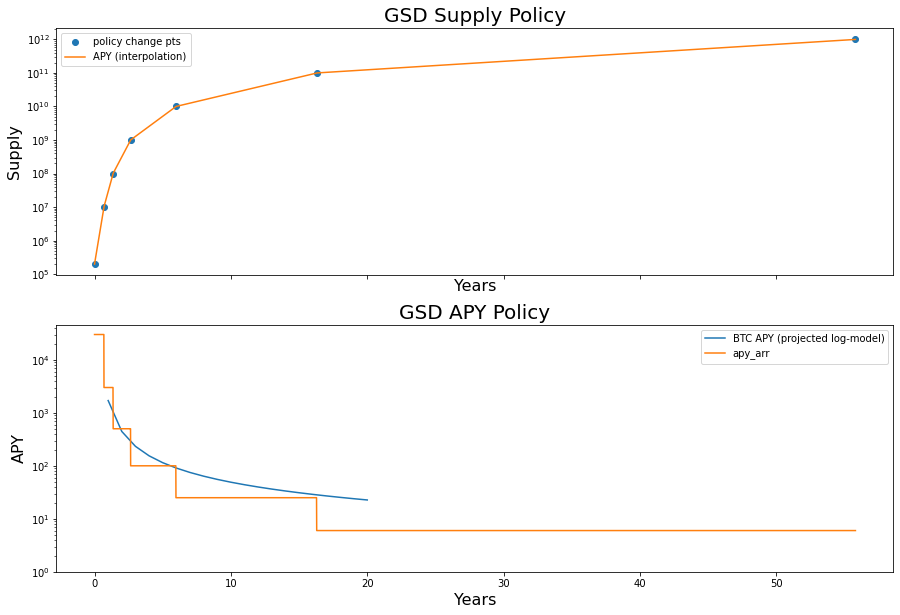

In [14]:
yrs_interp = np.arange(0,yrs[-1],1/(365*3))
supply_interp = np.exp(np.interp(yrs_interp, yrs, np.log(supply)))

rebase_arr = 100*(supply_interp[1:]/supply_interp[:-1] - 1)
rebase_arr = np.append(rebase_arr,rebase_arr[-1])
apy_arr = apy_return(rebase_arr,365*3)

fig, (supply_ax, apy_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(15, 10))

supply_ax.set_yscale('log')
supply_ax.plot(yrs, supply, 'o', label='policy change pts')
supply_ax.plot(yrs_interp, supply_interp, '-', markersize=3, label='APY (interpolation)')

supply_ax.set_ylabel('Supply', fontsize=16)
supply_ax.set_xlabel('Years', fontsize=16)
supply_ax.set_title("GSD Supply Policy", fontsize=20)
supply_ax.legend()

apy_ax.set_yscale('log')
apy_ax.plot(btc_yrs[:-1], apy_btc[1:], label='BTC APY (projected log-model)')
apy_ax.plot(yrs_interp, apy_arr, label='apy_arr')
apy_ax.set_ylabel('APY', fontsize=16)
apy_ax.set_xlabel('Years', fontsize=16)
apy_ax.set_title("GSD APY Policy", fontsize=20)
apy_ax.set_ylim(bottom=1)
apy_ax.legend()
fig.savefig('../img/gsd_apy.png')

#### Required Gold backing when supply hits 1 Trillion GSD

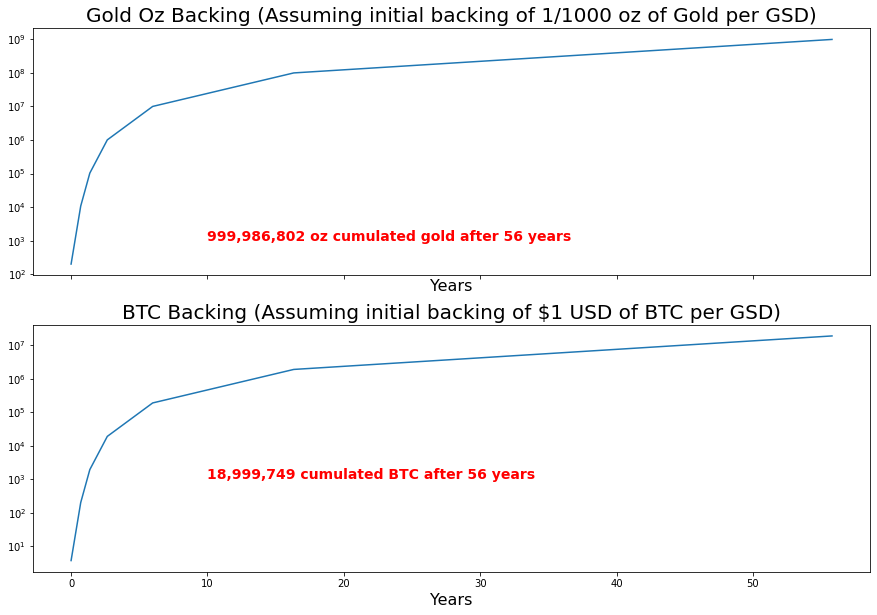

In [15]:
# gold_oz_per_gsi = 1/1782.60
gold_oz_per_gsi = 1/1000
btc_per_gsi = 0.000019
eth_per_gsi = 0.00024

btc_cummulation = btc_per_gsi*supply_interp
gold_oz_cummulation = gold_oz_per_gsi*supply_interp

gold_25_yrs = str(format(int(gold_oz_cummulation[-1]), ',d'))
btc_25_yrs = str(format(int(btc_cummulation[-1]), ',d'))

fig, (gold_ax, btc_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(15, 10))
gold_ax.set_yscale('log', subs=[1])
gold_ax.plot(yrs_interp, gold_oz_cummulation, label='GSD Price Expectation')
gold_ax.set_title("Gold Oz Backing (Assuming initial backing of 1/1000 oz of Gold per GSD)", fontsize=20)
gold_ax.text(10,1e3,'{} oz cumulated gold after {} years'.format(gold_25_yrs, round(yrs[-1])),
            weight="bold", color = 'red', fontsize=14)
gold_ax.set_xlabel('Years', fontsize=16)

btc_ax.set_yscale('log', subs=[1])
btc_ax.plot(yrs_interp, btc_cummulation, label='GSD Price Expectation')
btc_ax.set_title("BTC Backing (Assuming initial backing of $1 USD of BTC per GSD)", fontsize=20)
btc_ax.text(10,1e3,'{} cumulated BTC after {} years'.format(btc_25_yrs, round(yrs[-1])),
            weight="bold", color = 'red', fontsize=14)
btc_ax.set_xlabel('Years', fontsize=16)
fig.savefig('../img/backing.png')


#### Proposed price swing control policy
* USD Price of GSD should be alowed to float within an allocated range that goes in accordance to its corresponding APY and price control scedule
* For instance at the project onset where APY 9900\%, price is allowed to swing between \\$33 and \\$1194
* However when APY is much smaller at year 25 where APY is 25\%, price swings to excessive highs and lows do not provide enough incentive for participants to hold the asset, hence price is allowed to swing between \\$5.64 and \\$8.79 

In [22]:
apy_arr_schedule

array([3.00000000e+04, 1.15898712e+04, 2.17747273e+03, 4.95854537e+02,
       5.84823997e+01, 1.79320163e+01, 6.00000000e+00])

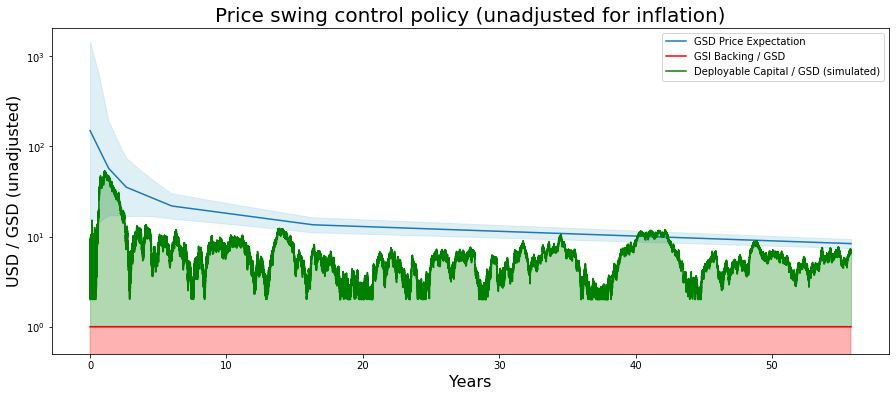

In [16]:
P0 = 150
a = apy_arr
p_control = np.exp(np.interp(yrs_interp, yrs, np.log(P0*p_control_schedule)))

apy_arr_schedule = apy_arr[(yrs*365*3).astype(int)]
apy_arr_swing = np.exp(np.interp(yrs_interp, yrs, np.log(apy_arr_schedule)))

p_swing = percent2X(5*np.sqrt(apy_arr_swing))
p_control_upr = p_control*p_swing
p_control_lwr = p_control/p_swing


deployable_capital = 2+p_control*gen_random_capital(len(yrs_interp)) 
backing = np.ones(len(yrs_interp))
bot = np.zeros(len(yrs_interp))

fig, ax = plt.subplots(figsize=(15, 6))
plt.yscale('log', subs=[1])
plt.plot(yrs_interp, p_control, label='GSD Price Expectation')
plt.plot(yrs_interp, backing,  color='red', label='GSI Backing / GSD')
plt.plot(yrs_interp, deployable_capital,  color='green', label='Deployable Capital / GSD (simulated)')
plt.fill_between(yrs_interp, p_control_lwr, p_control_upr, alpha=0.4, color='lightblue')

plt.fill_between(yrs_interp, bot, backing, alpha=0.3, color='red')
plt.fill_between(yrs_interp, backing, deployable_capital, alpha=0.3, color='green')
plt.title("Price swing control policy (unadjusted for inflation)", fontsize=20)
plt.ylabel("USD / GSD (unadjusted)", fontsize=16)
plt.xlabel("Years", fontsize=16)
plt.ylim(bottom=0.5)
plt.legend()
fig.savefig('../img/price_control.png')


#### Plot projections from initial investment of 1 GSD

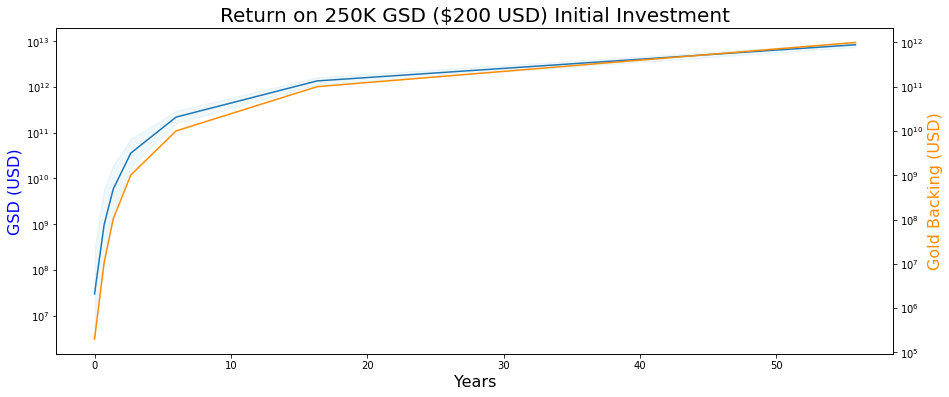

In [17]:
rebase = apy2Rebase(apy_arr,365*3)
rates = percent2X(rebase)

invest_gsd = np.array([200000])

for k in range(1,len(apy_arr)):
    invest_gsd = np.append(invest_gsd,invest_gsd[k-1]*rates[k-1])
    
invest_usd =  p_control*invest_gsd   
invest_usd_upr =  p_control_upr*invest_gsd 
invest_usd_lwr =  p_control_lwr*invest_gsd  
    
fig, gsd_ax = plt.subplots(figsize=(15, 6))
gold_ax = gsd_ax.twinx()
gsd_ax.set_yscale('log', subs=[1])
gold_ax.set_yscale('log', subs=[1])
gsd_ax.plot(yrs_interp, invest_usd, label='USD (unadjusted)')
gsd_ax.fill_between(yrs_interp, invest_usd_lwr, invest_usd_upr, alpha=0.2, color='lightblue')
gold_ax.plot(yrs_interp, invest_gsd, label='Gold Backing (units)',color='darkorange')
gsd_ax.set_title("Return on 250K GSD ($200 USD) Initial Investment", fontsize=20)
gsd_ax.set_ylabel("GSD (USD)", fontsize=16,color='blue')
gsd_ax.set_xlabel("Years", fontsize=16)
#gsd_ax.set_ylim(bottom=0.1,top=1.2e8)
#gold_ax.set_ylim(bottom=0.1,top=1.2e8)
gold_ax.set_ylabel("Gold Backing (USD)", fontsize=16,color='darkorange')
fig.savefig('../img/gsd_vs_gold_backing.png')

#### Tabulate projections from initial investment of 1 GSD

In [18]:
res = pd.DataFrame()

year_arr = np.array([0])
yoy_usd_arr = np.array([0])
yoy_gsd_arr = np.array([0])
year = -1

interval = int(365*3/12) 
interval = int(365*3/12) 

for k in range(len(invest_usd)):
    reset_year = k % interval == 0
    year = year + 1 if reset_year else year  
    if (reset_year):
        
        if(year > 0):
            year_arr = np.append(year_arr,year)
            yoy_usd = 100*(invest_usd[k] - invest_usd[k-interval])/invest_usd[k-interval]
            yoy_usd_arr = np.append(yoy_usd_arr,yoy_usd)
            yoy_gsd = 100*(invest_gsd[k] - invest_gsd[k-interval])/invest_gsd[k-interval]
            yoy_gsd_arr = np.append(yoy_gsd_arr,yoy_gsd)        
        
        # print('[{}] {:.0f} GDS -> {:.0f}% / {:.0f}% ret // {:.0f} USD -> {:.0f}% ret'.format(year,
        #                                                        invest_gsd[k],apy_arr[k],yoy_gsd_arr[-1],
        #                                                        invest_usd[k], yoy_usd_arr[-1],))  
        
        

#### Package tabulated results

In [19]:
indices = range(0,len(apy_arr),interval)

invest_gsd_arr_res = invest_gsd[indices]
apy_arr_res = apy_arr[indices]
invest_usd_arr_res = invest_usd[indices]

res = pd.DataFrame({'Month':year_arr.astype(int).flatten(),
                  'GSD':invest_gsd_arr_res.astype(int).flatten(),
                  'APY':apy_arr_res.astype(int).flatten(),
                  'GSD Return':yoy_gsd_arr.astype(int).flatten(),
                  'USD':invest_usd_arr_res.astype(int).flatten(),
                  'USD Return':yoy_usd_arr.astype(int).flatten(),
                  'Gold Backing':(invest_gsd_arr_res.flatten()/1000).astype(int),
                 })
res.set_index("Month", inplace = True)
res.head(36)

,GSD,APY,GSD Return,USD,USD Return,Gold Backing
Month,,,,,,
0,200000,29999,0,29999999,0,200
1,321374,29999,60,45474207,51,321
2,516407,30000,60,68930118,51,516
3,829801,30000,60,104484750,51,829
4,1333384,29999,60,158378707,51,1333
5,2142577,29999,60,240071540,51,2142
6,3442848,30000,60,363902101,51,3442
7,5532217,29999,60,551605323,51,5532
8,8889566,29999,60,836127165,51,8889
